In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

! pip install evaluate
! pip install sentence-transformers
! pip install SentencePiece
! pip install bert_score
! pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import evaluate
from evaluate import load
import datasets
from datasets import load_dataset

from transformers import T5Tokenizer,T5ForConditionalGeneration
import json

import torch

from transformers import pipeline

from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import matplotlib.pyplot as plt

import csv
from tqdm import tqdm
from transformers import pipeline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-03-31 10:17:43.506052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 10:17:43.506171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 10:17:43.647119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/t5-models/t5/T53/runs/Mar27_19-32-48_bdd4c7c63864/events.out.tfevents.1711567968.bdd4c7c63864.1600.0
/kaggle/input/t5-models/t5/T53/checkpoint-6250/config.json
/kaggle/input/t5-models/t5/T53/checkpoint-6250/trainer_state.json
/kaggle/input/t5-models/t5/T53/checkpoint-6250/spiece.model
/kaggle/input/t5-models/t5/T53/checkpoint-6250/training_args.bin
/kaggle/input/t5-models/t5/T53/checkpoint-6250/tokenizer.json
/kaggle/input/t5-models/t5/T53/checkpoint-6250/tokenizer_config.json
/kaggle/input/t5-models/t5/T53/checkpoint-6250/scheduler.pt
/kaggle/input/t5-models/t5/T53/checkpoint-6250/model.safetensors
/kaggle/input/t5-models/t5/T53/checkpoint-6250/special_tokens_map.json
/kaggle/input/t5-models/t5/T53/checkpoint-6250/optimizer.pt
/kaggle/input/t5-models/t5/T53/checkpoint-6250/rng_state.pth
/kaggle/input/t5-models/t5/T53/checkpoint-6250/generation_config.json
/kaggle/input/t5-models/t5/T53/checkpoint-9375/config.json
/kaggle/input/t5-models/t5/T53/checkpoint-9375/trainer_sta

In [3]:
def create_loss_graphs(file_path):
    loader = EventFileLoader(file_path)
    
    train_loss = []
    val_loss = []
    epoch_loss = [] # Accumulator for the current epoch's loss

    x=[1,2,3,4,5]
    for event in loader.Load():
        step = event.step
        dicts = event.summary.value

        for dict in dicts:
            if dict.tag == "train/loss":
                epoch_loss.append(dict.tensor.float_val[0])  # Accumulate loss

        # Check if it's the end of an epoch (every 500 steps)
        if step % 2000 == 0:
            for dict in dicts:
                if dict.tag == "eval/loss":
                    val_loss.append(dict.tensor.float_val[0])
                    avg_loss = np.average(epoch_loss)
                    train_loss.append(avg_loss)
                    epoch_loss=[]

    plt.plot(x,train_loss,'b',label="Training Loss")
    plt.plot(x,val_loss,'g',label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()


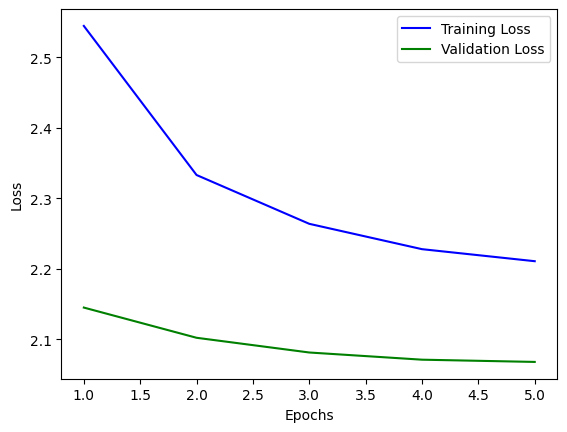

In [4]:
create_loss_graphs('/kaggle/input/t5-25-5/T5/runs/Mar28_19-38-40_21982f24fff4/events.out.tfevents.1711654720.21982f24fff4.26.0')

In [5]:
bertscore = load("bertscore")
meteor = evaluate.load("meteor")
bleu = evaluate.load("bleu")
# tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
# model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small").to(device)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# Testing

In [6]:
import datasets
import csv

# Load the val dataset
test_data = datasets.load_dataset('wmt16', 'de-en', split='test')


# Path to save the CSV file
csv_file_path = 'wmt16_test.csv'

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    # Define the fieldnames for the CSV
    fieldnames = ['de', 'en']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the header row
    writer.writeheader()
    
    # Iterate through the test dataset and write each item to the CSV file
    for item in test_data:
        writer.writerow({'de': item['translation']['de'], 'en': item['translation']['en']})

print(f"CSV file saved successfully at: {csv_file_path}")


Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

Dataset wmt16 downloaded and prepared to /root/.cache/huggingface/datasets/wmt16/de-en/1.0.0/9e0038fe4cc117bd474d2774032cc133e355146ed0a47021b2040ca9db4645c0. Subsequent calls will reuse this data.
CSV file saved successfully at: wmt16_test.csv


# Validation

In [7]:
import datasets
import csv

# Load the val dataset
val_data = datasets.load_dataset('wmt16', 'de-en', split='validation')


# Path to save the CSV file
csv_file_path_val = 'wmt16_val.csv'

# Open the CSV file in write mode
with open(csv_file_path_val, 'w', newline='', encoding='utf-8') as csvfile:
    # Define the fieldnames for the CSV
    fieldnames = ['de', 'en']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the header row
    writer.writeheader()
    
    # Iterate through the val dataset and write each item to the CSV file
    for item in val_data:
        writer.writerow({'de': item['translation']['de'], 'en': item['translation']['en']})

print(f"CSV file saved successfully at: {csv_file_path_val}")


CSV file saved successfully at: wmt16_val.csv


In [8]:
csv_file_path = 'wmt16_test.csv'
csv_file_path_val = 'wmt16_val.csv'
model_path = "/kaggle/input/t5-25-5/T5_overall"

In [9]:
en_test_data = []
de_test_data = []
en=False
# Read data from the CSV file
with open(csv_file_path, 'r', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    i=0
    if 'en' in reader.fieldnames:
        en=True
    for row in reader:
        if en:
            en_test_data.append(row['en'])
        else:
            en_test_data.append(i)
        de_test_data.append(row['de'])
        i+=1
# Prepare data for translation 
prefix = "translate German to English: "
test_model_input = [prefix + sentence for sentence in de_test_data]

# Initialize the translation pipeline
translator = pipeline("translation_XX_to_YY", model=model_path)

# Perform translation
test_output = []

# Translate each sentence
for sentence in tqdm(test_model_input):
    decoded_output = translator(sentence, max_length=128)
    translated_text = decoded_output[0]["translation_text"]
    test_output.append(translated_text)

# Check the length of the output
print("Number of translations:", len(test_output))

translated_csv_file_path = 'translated_2C_test.csv'

# Write translated outputs to CSV
with open(translated_csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['en', 'de', 'translated_de']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for en, de, translated_de in zip(en_test_data, de_test_data, test_output):
        writer.writerow({'en': en, 'de': de, 'translated_de': translated_de})

print(f"Translated CSV file saved successfully at: {translated_csv_file_path}")

100%|██████████| 2999/2999 [24:44<00:00,  2.02it/s]

Number of translations: 2999
Translated CSV file saved successfully at: translated_2C_test.csv


In [10]:
en_val_data = []
de_val_data = []
en=False
# Read data from the CSV file
with open(csv_file_path_val, 'r', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    i=0
    if 'en' in reader.fieldnames:
        en=True
    for row in reader:
        if en:
            en_val_data.append(row['en'])
        else:
            en_val_data.append(i)
        de_val_data.append(row['de'])
        i+=1
# Prepare data for translation 
prefix = "translate German to English: "
val_model_input = [prefix + sentence for sentence in de_val_data]

# Initialize the translation pipeline
translator = pipeline("translation_XX_to_YY", model=model_path)

# Perform translation
val_output = []

# Translate each sentence
for sentence in tqdm(val_model_input):
    decoded_output = translator(sentence, max_length=128)
    translated_text = decoded_output[0]["translation_text"]
    val_output.append(translated_text)

# Check the length of the output
print("Number of translations:", len(val_output))

translated_csv_file_path_val = 'translated_2C_val.csv'

# Write translated outputs to CSV
with open(translated_csv_file_path_val, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['en', 'de', 'translated_de']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for en, de, translated_de in zip(en_val_data, de_val_data, val_output):
        writer.writerow({'en': en, 'de': de, 'translated_de': translated_de})

print(f"Translated CSV file saved successfully at: {translated_csv_file_path_val}")

100%|██████████| 2169/2169 [17:08<00:00,  2.11it/s]

Number of translations: 2169
Translated CSV file saved successfully at: translated_2C_val.csv


In [11]:
def calculate_bleu(bp,precisions):
    weights_1 = np.array([1,0,0,0])
    weights_2 = np.array([0.5,0.5,0,0])
    weights_3 = np.array([0.33,0.33,0.33,0])
    weights_4 = np.array([0.25,0.25,0.25,0.25])
    logp = np.log(precisions)
        
    res1 = bp*np.exp(np.dot(logp,weights_1))
    res2 = bp*np.exp(np.dot(logp,weights_2))
    res3 = bp*np.exp(np.dot(logp,weights_3))
    res4 = bp*np.exp(np.dot(logp,weights_4))
    
    return [res1,res2,res3,res4]

# Testing Data

In [12]:
bleu_score = bleu.compute(predictions=test_output, references=en_test_data)
results = calculate_bleu(bleu_score["brevity_penalty"],bleu_score["precisions"])

print("Bleu Score : ")
print(bleu_score)
print("Bleu-1 : ",results[0])
print("Bleu-2 : ",results[1])
print("Bleu-3 : ",results[2])
print("Bleu-4 : ",results[3])

Bleu Score : 
{'bleu': 0.18631443592838234, 'precisions': [0.5149153780591745, 0.24173510884299498, 0.13028623109518148, 0.07430395147497046], 'brevity_penalty': 1.0, 'length_ratio': 1.0247196618786942, 'translation_length': 65704, 'reference_length': 64119}
Bleu-1 :  0.5149153780591745
Bleu-2 :  0.35280748994326416
Bleu-3 :  0.25662056545202483
Bleu-4 :  0.18631443592838243


In [13]:
results = meteor.compute(predictions=test_output, references=en_test_data)
print("Meteor Score : ",results)

Meteor Score :  {'meteor': 0.482836945224529}


In [14]:
results = bertscore.compute(predictions=test_output, references=en_test_data, lang="en")
print("Bert Score : ")
print("F1 = ",np.average(results["f1"]))
print("Precision = ",np.average(results["precision"]))
print("Recall = ",np.average(results["recall"]))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bert Score : 
F1 =  0.9082672969624773
Precision =  0.90533397059792
Recall =  0.9114253632662176


# Validation Data

In [15]:
bleu_score = bleu.compute(predictions=val_output, references=en_val_data)
results = calculate_bleu(bleu_score["brevity_penalty"],bleu_score["precisions"])

print("Bleu Score : ")
print(bleu_score)
print("Bleu-1 : ",results[0])
print("Bleu-2 : ",results[1])
print("Bleu-3 : ",results[2])
print("Bleu-4 : ",results[3])

Bleu Score : 
{'bleu': 0.16199972626253512, 'precisions': [0.4952077370110157, 0.2141215555100462, 0.10981067949546444, 0.060853104492680464], 'brevity_penalty': 0.9929342660416197, 'length_ratio': 0.9929591111685292, 'translation_length': 46116, 'reference_length': 46443}
Bleu-1 :  0.4917087308871644
Bleu-2 :  0.3233288100658554
Bleu-3 :  0.22841834845352804
Bleu-4 :  0.16199972626253514


In [16]:
results = meteor.compute(predictions=val_output, references=en_val_data)
print("Meteor Score : ",results)

Meteor Score :  {'meteor': 0.44040263189941226}


In [17]:
results = bertscore.compute(predictions=val_output, references=en_val_data, lang="en")
print("Bert Score : ")
print("F1 = ",np.average(results["f1"]))
print("Precision = ",np.average(results["precision"]))
print("Recall = ",np.average(results["recall"]))

Bert Score : 
F1 =  0.9048136848082131
Precision =  0.902531928678656
Recall =  0.9073259996730317


# Inference Pipeline for translating input sentences

In [18]:
def create_translation(sentence):
    prefix = "translate German to English: "
    prefix_sent = prefix+sentence
    translation = pipeline("translation_XX_to_YY",model=model_path)
    return translation(prefix_sent)

In [19]:
sentence = "Hallo Leute"
trans_sentence = create_translation(sentence)
trans_sentence

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'translation_text': 'Hallo people'}]